In [1]:
import pandas as pd

# Replace 'path_to_file' with the actual path to your file
df = pd.read_csv('mini_sample.xls')

df = df[['reviewText', 'overall']]
df['overall'] = df['overall'] - 1  # Adjust labels to start from 0


print(df)

                                             reviewText  overall
0     This is one my must have books. It is a master...      4.0
1     This book provides a reflection that you can a...      4.0
2     I first read THE PROPHET in college back in th...      4.0
3     A timeless classic.  It is a very demanding an...      4.0
4     Reading this made my mind feel like a still po...      4.0
...                                                 ...      ...
1021  To make my point I'll be as concise as possibl...      0.0
1022  This is a book that I can't put down, until 2 ...      3.0
1023  I started this book with the idea that it woul...      3.0
1024  This novel was beautifully written.  Amy Tan o...      3.0
1025  The Professor and the Madman deals with the ro...      3.0

[1026 rows x 2 columns]


In [2]:
df['overall'] = df['overall'].astype(int)
# Using the dtype attribute
overall_dtype = df['overall'].dtype
print("Data type of 'overall' column:", overall_dtype)

Data type of 'overall' column: int64


In [3]:
# Specify the path where you want to save the CSV file
file_path = "MINI_SAMPLE.csv"

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)  # Set index=False to exclude row indices in the CSV

print(f"DataFrame saved to {file_path}")

DataFrame saved to MINI_SAMPLE.csv


In [4]:
!pip install datasets


In [5]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files="MINI_SAMPLE.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'overall'],
        num_rows: 1026
    })
})

In [7]:
from sklearn.model_selection import train_test_split
from datasets import DatasetDict
from datasets import Dataset, DatasetDict


# Assuming 'dataset' is your DatasetDict object containing the training split
train_dataset = dataset['train']

# Split the training dataset into train and test sets
train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)

# Convert the splits to Dataset objects
train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)

# Now you have train_dataset and test_dataset containing the training and test data

# Create a new DatasetDict object to hold the splits
split_dataset = DatasetDict({'train': train_dataset, 'validation': val_dataset})


In [8]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'overall'],
        num_rows: 820
    })
    validation: Dataset({
        features: ['reviewText', 'overall'],
        num_rows: 206
    })
})

In [9]:
!pip install transformers[torch] evaluate accelerate

In [10]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2", padding=True)
tokenizer.pad_token = tokenizer.eos_token


In [11]:
def tokenize_function(examples):
    return tokenizer(examples["reviewText"], truncation=True)

# Now you can use the .map() method on the train_dataset
tokenized_datasets = split_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/820 [00:00<?, ? examples/s]

Map:   0%|          | 0/206 [00:00<?, ? examples/s]

In [12]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['reviewText', 'overall', 'input_ids', 'attention_mask'],
        num_rows: 820
    })
    validation: Dataset({
        features: ['reviewText', 'overall', 'input_ids', 'attention_mask'],
        num_rows: 206
    })
})

In [13]:
#ADDING EXTRA
tokenized_datasets = tokenized_datasets.remove_columns(["reviewText"])
tokenized_datasets = tokenized_datasets.rename_column("overall", "labels")

In [14]:
#ADDING NEW EXTRA
tokenized_datasets = tokenized_datasets.with_format("torch")

In [15]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 820
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 206
    })
})

In [16]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [17]:
#from transformers import GPT2Model, TrainingArguments, Trainer
#import torch
from transformers import GPT2ForSequenceClassification, TrainingArguments, Trainer
#model = GPT2Model.from_pretrained("openai-community/gpt2", num_labels=5)
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=5)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
import evaluate

accuracy = evaluate.load("accuracy")

In [19]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [23]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/opt/conda/envs/sagemaker-distribution/lib/python3.8/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 4.14.336, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.727261,0.669903
2,0.026700,4.193587,0.597087
3,0.026700,4.378454,0.684466
4,0.013900,3.786592,0.674757
5,0.013900,4.195048,0.699029
6,0.002900,4.121271,0.699029
7,0.002900,3.955662,0.689320
8,0.009000,3.952964,0.689320


TrainOutput(global_step=2192, training_loss=0.011974190032866105, metrics={'train_runtime': 566.6836, 'train_samples_per_second': 11.576, 'train_steps_per_second': 3.868, 'total_flos': 839606457116160.0, 'train_loss': 0.011974190032866105, 'epoch': 8.0})

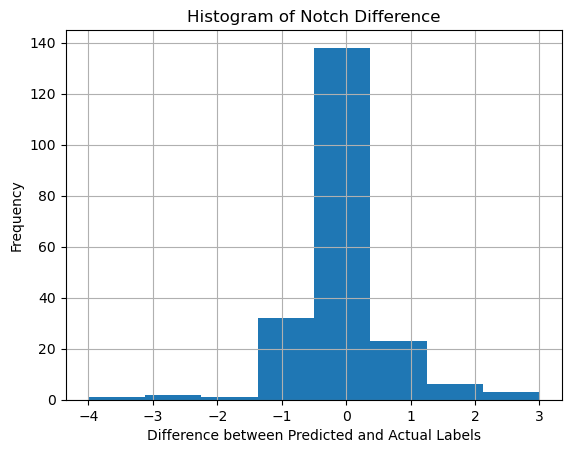

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# After trainer.train()
eval_results = trainer.predict(tokenized_datasets["validation"])

# Extract the predicted labels from the evaluation results
predicted_labels = np.argmax(eval_results.predictions, axis=1)

# Convert actual labels to NumPy array
actual_labels = tokenized_datasets["validation"]["labels"].numpy()

# Compute the difference between predicted and actual labels
difference = predicted_labels - actual_labels

# Plot histogram of the difference
plt.hist(difference, bins=len(np.unique(difference)))
plt.xlabel("Difference between Predicted and Actual Labels")
plt.ylabel("Frequency")
plt.title("Histogram of Notch Difference")
plt.grid(True)
plt.show()
